# Goal: Align raw tiles from all rounds

## Step 1. [raw stitches] Generation

In [1]:
import h5py
import numpy as np
import os
import exm
import matplotlib.pyplot as plt
import tifffile
import multiprocessing as mp
from exm.io import readXlsx, readNd2,tiles, readH5, writeH5, mkdir, tilesData,imAdjust,tiff2H5
from exm.align import sitkTile, sitkTile2Volume

D0 = '/mp/nas3/WORMSeq7_Full3Rounds/WORMseq7_YoungAdult/'
Do = '/home/donglai/align/db/wormseq7/'

round_names = ['barcode3','barcode5','barcode6']
round_names = ['barcode3']

channel_name = '405 SD'

# for low-res registration
mip_lr = 3
transform_type = 'rigid' # good enough, more robust
ratio_lr = [2**mip_lr for i in range(3)]
im_thres = [0, 255, False] 
cell_thres = 120
mkdir(Do + 'lr/')

sn_tiles_lr = Do + 'lr/%s_lr-raw.h5'
sn_transform_lr = Do + 'lr/%s-%s_lr-raw_'+'%s.txt' % transform_type
sn_tiles_warp_lr = Do + 'lr/%s-%s_lr-raw_'+'%s_warped.h5' % transform_type
num_round = len(round_names)


tiles_data = [None] * num_round
for i,round_name in enumerate(round_names):
    round_folder = D0 + 'WORMseq7_YoungAdult_%s/' % round_name
    round_xlsx = round_folder + 'YoungAdult_%s_405.xlsx' % round_name
    round_nd2 = round_folder + 'Channel405 SD_Seq0004.nd2' 
    tiles_nd2, tiles_info = readNd2(round_nd2)
    tiles_loc = readXlsx(round_xlsx)

    tiles_data[i] = tilesData(tiles_nd2, tiles_info, tiles_loc)
    tiles_data[i].setChannel(channel_name)
    tiles_data[i].setRatio(ratio_lr)
    tiles_data[i].setImThres(im_thres)

    if not os.path.exists(sn_tiles_lr % round_name):
        print('creating low-res raw-stitch for',round_name)
        tiles_lr_vol = tiles_data[i].getTileRawStitch()
        writeH5(sn_tiles_lr % round_name, tiles_lr_vol)

exist 3 multipoint loops with length [4 4 9]
['405 SD']
original size:  [ 559 9819 5969] (downsampled): [  70 1228  747]


## Convert nd2 to h5 for parallel tile alignment

In [2]:
"""
def convertNd2ToH5(round_id):
    if not os.path.exists(fn_out%(ratio_hr[0], tile_id) + '.h5'):
        chunk_size = [128,1024,1024]
        fid = h5py.File(stitch_out, 'w')
        tile_size = tiles_data[round_id].tiles_size
        for tile_id in range(tiles_data[round_id].tiles_num):
            print('round-%d, tile-%d' % (round_id, tile_id))
            ds = fid.create_dataset('tile-%d'%tile_id, tile_size, compression="gzip", dtype=np.uint8, chunks=tuple(chunk_size))
            ds[:] = tiles_data[round_id].getTileVolume(tile_id)
        fid.close()

pool = mp.Pool(min(num_round, mp.cpu_count()))
pool.map(convertNd2ToH5, range(num_round))
"""

'\ndef convertNd2ToH5(round_id):\n    if not os.path.exists(fn_out%(ratio_hr[0], tile_id) + \'.h5\'):\n        chunk_size = [128,1024,1024]\n        fid = h5py.File(stitch_out, \'w\')\n        tile_size = tiles_data[round_id].tiles_size\n        for tile_id in range(tiles_data[round_id].tiles_num):\n            print(\'round-%d, tile-%d\' % (round_id, tile_id))\n            ds = fid.create_dataset(\'tile-%d\'%tile_id, tile_size, compression="gzip", dtype=np.uint8, chunks=tuple(chunk_size))\n            ds[:] = tiles_data[round_id].getTileVolume(tile_id)\n        fid.close()\n\npool = mp.Pool(min(num_round, mp.cpu_count()))\npool.map(convertNd2ToH5, range(num_round))\n'

## Step 1. [raw stitches] Align to the reference round with biggest z

In [3]:
zmax, rid = 0, -1
for i,round_name in enumerate(round_names):
    sz = h5py.File(sn_tiles_lr% round_name, 'r')['main'].shape
    if sz[0] > zmax:
        zmax, rid = sz[0], i
    print(round_name, sz)
print('Align low-res to round:', round_names[rid])
print('--------')

round_name_ref = round_names[rid]
tiles_vol_lr_ref = readH5(sn_tiles_lr % round_name_ref)
sz_ref = tiles_data[rid].getVolumeSize(ratio_lr)


aligner = sitkTile()
# zyx -> xyz order
aligner.setResolution(tiles_data[0].getResolution(ratio_lr)[::-1])
aligner.setTransformType([transform_type], num_iteration=5000)

transform_lr = [None] * len(round_names)

for i, round_name in enumerate(round_names):
    if i != rid:
        sn = sn_transform_lr % (round_name_ref,round_name)
        sn_w = sn_tiles_warp_lr % (round_name_ref,round_name)
        if not os.path.exists(sn):
            print('Aligning %s to %s' % (round_name,round_name_ref))
            tiles_vol_lr = readH5(sn_tiles_lr % round_name)
            transform_lr[i] = aligner.computeTransformMap(tiles_vol_lr_ref, tiles_vol_lr,\
                                        mask_fix = (tiles_vol_lr_ref>0).astype(np.uint8),\
                                        mask_move = (tiles_vol_lr>0).astype(np.uint8))
            aligner.writeTransformMap(sn, transform_lr[i])
        transform_lr[i] = aligner.readTransformMap(sn)

        if not os.path.exists(sn_w):
            print('Warping')            
            tiles_vol_lr_warp = aligner.warpVolume(tiles_vol_lr, transform_lr[i]).astype(np.uint8)
            writeH5(sn_w, tiles_vol_lr_warp)


# identity transformation
if num_round == 1:
    aligner.setTransformType([transform_type], num_iteration=1)
    transform_lr[rid] = aligner.computeTransformMap(tiles_vol_lr_ref, tiles_vol_lr_ref,\
                                        mask_fix = (tiles_vol_lr_ref>0).astype(np.uint8),\
                                        mask_move = (tiles_vol_lr_ref>0).astype(np.uint8))
    aligner.setTransformType([transform_type], num_iteration=5000)
else:
    transform_lr[rid] = aligner.readTransformMap(sn)
    center_pt = tiles_data[rid].getResolution(ratio_lr) * sz_ref
    transform_lr[rid]['CenterOfRotationPoint'] = tuple([str(x) for x in center_pt[::-1]/2])
    if transform_type == 'rigid':
        transform_lr[rid]["TransformParameters"] = tuple([str(x) for x in np.zeros(6,int)])

barcode3 (70, 1228, 747)
Align low-res to round: barcode3
--------


## Step 2. [raw stitches] Estimating the template

In [22]:
# setup index volume
ind= [None] * len(round_names)
for i, round_name in enumerate(round_names):
    ind[i] = tiles_data[i].getTileRawStitchIndex()
    if i != rid:
        sn = sn_transform_lr % (round_name_ref,round_name)
        # nearest neighbor wparping
        transform_lr[i]['FinalBSplineInterpolationOrder'] = ['0']
        ind[i] = aligner.warpVolume(ind[i], transform_lr[i]).astype(np.uint8)
        transform_lr[i]['FinalBSplineInterpolationOrder'] = ['1']            

In [25]:
# initial empty template
template = np.zeros(h5py.File(sn_tiles_lr% round_name_ref, 'r')['main'].shape, np.uint8)

# setup tile2volume 
def getVolume(z0,z1,y0,y1,x0,x1):
    return template[z0:z1, y0:y1, x0:x1]

aligner_t2v = [None] * 3
for i in range(len(round_names)):
    aligner_t2v[i] = sitkTile2Volume(tiles_data[i], getVolume, aligner, ratio_lr)
    aligner_t2v[i].setInitialTransform(transform_lr[i])
    aligner_t2v[i].updateOutputSize(pad_ratio = 3)
    #aligner_t2v[i].setMaskThreshold(cell_thres)
    

original size:  [ 559 9819 5969] (downsampled): [  70 1228  747]


In [26]:
# initialization
# start from the middle tile in the ref
for pad in range(5)[::-1]:
    # ind index starts at 1
    pad = np.maximum(np.ones(3, int), sz_ref//(2**pad))
    sids = ind[rid][sz_ref[0]//2-pad[0] : sz_ref[0]//2+pad[0],\
                   sz_ref[1]//2-pad[1] : sz_ref[1]//2+pad[1],\
                   sz_ref[2]//2-pad[2] : sz_ref[2]//2+pad[2]]
    if sids.max() > 0:
        ui, uc = np.unique(sids[sids>0], return_counts=True)
        sid = ui[np.argmax(uc)]-1
        break

fn_lr = Do + 'template/'+ transform_type + '-%d'
sn = fn_lr%rid + '-%d-%d' % (sid, aligner_t2v[rid].ratio_output[0])
if not os.path.exists(sn + '_transform.txt'):
    aligner.writeTransformMap(sn + '_transform.txt', transform_lr[rid])
if not os.path.exists(sn + '_coord.txt'):
    top_left = tiles_data[rid].getTilePixPosition(sid).astype(int)
    np.savetxt(sn + '_coord.txt', top_left, '%d')
else:
    top_left = np.loadtxt(sn + '_coord.txt').astype(int)
    
if not os.path.exists(sn + '.h5'):
    tiles_vol = tiles_data[rid].getTileVolume(tiles_data[rid].tiles_loc[sid, -1], ratio_lr, im_thres)
    writeH5(sn + '.h5', tiles_vol)
else:
    tiles_vol = readH5(sn + '.h5')


template[top_left[0]:top_left[0]+tiles_vol.shape[0],\
        top_left[1]:top_left[1]+tiles_vol.shape[1],\
        top_left[2]:top_left[2]+tiles_vol.shape[2]] = tiles_vol

num_tiles = np.array([tiles_data[x].tiles_num for x in range(len(round_names))])
ind_done = np.ones([len(round_names), num_tiles.max()])

for i in range(len(round_names)):
    ind_done[:num_tiles[i]] = 0    
ind_done[rid,sid] = 1
ind[rid][ind[rid] == sid+1] = 0

In [28]:
rid,sid

(0, 4)

In [29]:
# for loop
mkdir(Do + 'template/')

while ind_done.min() == 0:
    # find the tile with largest overlap
    olap_round, olap_tile, olap_voxel = -1, -1, 0
    for i in range(len(round_names)):
        # foreground cell region overlap
        tmp = ind[i][template>cell_thres]
        if tmp.max()>0:
            ui, uc = np.unique(tmp[tmp>0], return_counts=True)
            if uc.max() > olap_voxel:
                olap_round, olap_tile = i, ui[np.argmax(uc)]-1
                olap_voxel = uc.max()
                
    print('stitch round%d-tile%d'%(olap_round, olap_tile))
    # align it    
    sn = fn_lr%olap_round + '-%d-%d' % (olap_tile, aligner_t2v[olap_round].ratio_output[0])
    if not os.path.exists(sn + '.h5'):
        aligner_t2v[olap_round].alignTiles(olap_tile, fn_lr%olap_round, True)
    
    ind_done[olap_round, olap_tile] = 1
    ind[olap_round][ind[olap_round] == olap_tile+1] = 0

    # update template
    if os.path.exists(sn + '.h5'):
        vol_top_left = np.loadtxt(sn + '_coord.txt').astype(int)
        tile_output = readH5(sn + '.h5')
        vol_bottom_right = vol_top_left+tile_output.shape
        vol = template[vol_top_left[0] : vol_bottom_right[0],
                        vol_top_left[1] : vol_bottom_right[1],\
                        vol_top_left[2] : vol_bottom_right[2]]
        template[vol_top_left[0] : vol_bottom_right[0],
                vol_top_left[1] : vol_bottom_right[1],\
                vol_top_left[2] : vol_bottom_right[2]] = np.maximum(vol, tile_output)

stitch round0-tile7
stitch round0-tile5
stitch round0-tile6
stitch round-1-tile-1


AttributeError: 'NoneType' object has no attribute 'ratio_output'

In [35]:
aligner_t2v[0].aligner.parameter_map.values()

[('true',),
 ('true',),
 ('false',),
 ('0.0',),
 ('1',),
 ('FixedSmoothingImagePyramid',),
 ('RandomCoordinate',),
 ('LinearInterpolator',),
 ('5000',),
 ('100',),
 ('AdvancedMattesMutualInformation',),
 ('MovingSmoothingImagePyramid',),
 ('true',),
 ('1',),
 ('5000',),
 ('2048',),
 ('AdaptiveStochasticGradientDescent',),
 ('MultiResolutionRegistration',),
 ('FinalBSplineInterpolator',),
 ('DefaultResampler',),
 ('nii',),
 ('EulerTransform',),
 ('false',),
 ('true',)]

In [30]:
for i in range(num_round):
    aligner_t2v[i].stitchTiles(sz_ref, fn_lr%i, 'db%d.h5'%i, [64,512,512])

Load tile 1:  pos= [  0 243 243]
Load tile 4:  pos= [  0 486 244]
Load tile 5:  pos= [  1 486 487]
Load tile 6:  pos= [  1 727 489]
Load tile 7:  pos= [  1 729 246]


In [ ]:
writeH5('template.h5', template)

In [ ]:
ind_done

In [ ]:
olap_round, olap_tile, olap_voxel = -1, -1, 0
for i in range(len(round_names)):
    # foreground cell region overlap
    tmp = ind[i][template>150]
    if tmp.max()>0:
        ui, uc = np.unique(tmp[tmp>0], return_counts=True)
        if uc.max() > olap_voxel:
            olap_round, olap_tile = i, ui[np.argmax(uc)]-1
            olap_voxel = uc.max()



In [ ]:
olap_round, olap_tile, olap_voxel

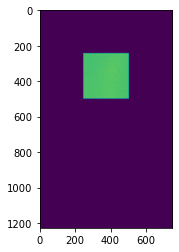

In [15]:
plt.imshow(template[30])

In [ ]:
ind_done[olap_round, olap_tile] = 1
ind[olap_round][ind[olap_round] == olap_tile+1] = 0

# update template
sn = fn_lr % (olap_tile,aligner_t2v[olap_round].ratio_output[0])
if os.path.exists(sn + '.h5'):
    vol_top_left = np.loadtxt(sn + '_coord.txt').astype(int)
    tile_output = readH5(sn + '.h5')
    vol_bottom_right = vol_top_left+tile_output.shape
    vol = template[vol_top_left[0] : vol_bottom_right[0],
                    vol_top_left[1] : vol_bottom_right[1],\
                    vol_top_left[2] : vol_bottom_right[2]]
    template[vol_top_left[0] : vol_bottom_right[0],
            vol_top_left[1] : vol_bottom_right[1],\
            vol_top_left[2] : vol_bottom_right[2]] = np.maximum(vol, tile_output)

In [ ]:
olap_round, olap_tile = 2, 4
fn_lr = Do + 'template/'+ transform_type + str(olap_round)+'-%d-%d'
aligner_t2v[olap_round].alignTiles(olap_tile, fn_lr, True)

In [ ]:
olap_round, olap_tile 

In [ ]:
for i in range(3):
    plt.subplot(1,3,i+1)
    tiles_data[i].displayTileLoc()

In [ ]:
aligner.transformix.PrintParameterMap()


## Step 0. Parameter setup

In [ ]:
import h5py
import numpy as np
import os
import exm
import matplotlib.pyplot as plt
import tifffile
import multiprocessing as mp
from exm.io import readXlsx, readNd2,tiles, readH5, writeH5, mkdir, tilesData,imAdjust,tiff2H5
from exm.align import sitkTile, sitkTile2Volume


############# To change #############
## 1. File paths
# input
D0 = '/mp/nas3/WORMSeq7_Full3Rounds/WORMseq7_YoungAdult/'
Ds = D0 + 'WORMseq7_YoungAdult_barcode3/Base3/output/'
# output
Do = '/home/donglai/align/db/wormseq7/'


## 2. Stitched volume: convert tif output to h5
#align_method = 'bigstitcher'
align_method = 'terastitcher'
bigstitcher_h5 = Do + 'barcode3_hr.h5'
# if no h5 yet, need conversion
terastitcher_hr_tif = Ds + 'RES(9854x5950x548)/000000/000000_000000/000000_000000_000040.tif'
terastitcher_lr_tif = Ds + 'RES(1231x743x68)/000000/000000_000000/000000_000000_000040.tif'



## 3. Tiles from other rounds
#fn_name = 'barcode5'
fn_name = 'barcode6'
fn_tiles_folder = D0 + 'WORMseq7_YoungAdult_%s/' % fn_name
fn_tiles_nd2 = fn_tiles_folder + 'Channel405 SD_Seq0004.nd2' 
fn_tiles_channel = '405 SD'
fn_tiles_xlsx = fn_tiles_folder + 'YoungAdult_%s_405.xlsx' % fn_name


## 4. Registration
# threshold the range to change from uint16 to uint8
# do not rescale the tiles as some background tiles can be over-scaled
transform_type = 'rigid' # good enough, more robust
#transform_type = 'affine'
mip_lr = 3 # for low-res registration
im_thres = [0, 255, False] 

do_debug = True # for debug


############# No change #############
ratio_lr = [2**mip_lr for i in range(3)]
stitched_hr_h5 = Do + 'barcode3_hr.h5'
stitched_lr_h5 = Do + 'barcode3_lr.h5'
Do = Do + '/'
mkdir(Do)
mkdir(Do + fn_name)
fn_out = Do + fn_name + '/'+ transform_type + '_%d-%d'

# save intermediate low-res results
mkdir(Do + 'lr/')
sn_tiles_lr = Do + 'lr/%s_lr-raw.h5' % fn_name
sn_transform_lr = Do + 'lr/%s_lr-raw_%s.txt' % (fn_name, transform_type)
sn_tiles_warp_lr = Do + 'lr/%s_lr-raw_%s_warped.h5' % (fn_name, transform_type)

# Step 0. Data conversion

In [ ]:
if not os.path.exists(stitched_hr_h5):
    tiff2H5(terastitcher_hr_tif, stitched_hr_h5, chunk_size=(100,1024,1024), step=100)

if align_method == 'bigstitcher':
    stitched_hr_h5_vol = h5py.File(stitched_hr_h5, 'r')['t00000']['s00']['0']['cells']
elif align_method == 'terastitcher':
    stitched_hr_h5_vol = h5py.File(stitched_hr_h5, 'r')['main']

## Step 1. Low-res volume-to-volume registration

### 1.1 Low-res stitched volume

In [ ]:
if align_method == 'bigstitcher':
    stitched_lr_h5_vol = np.array(h5py.File(bigstitcher_h5, 'r')['t00000']['s00'][str(mip_lr)]['cells'])    
elif align_method == 'terastitcher':
    if not os.path.exists(stitched_lr_h5):
        stitched_lr_vol = tifffile.imread(terastitcher_lr_tif)
        writeH5(stitched_lr_h5, stitched_lr_vol)
    else:
        stitched_lr_vol = readH5(stitched_lr_h5)
    stitched_lr_h5_vol = h5py.File(stitched_lr_h5, 'r')['main']

In [ ]:
if do_debug and False:
    # check out the image value distribution
    stitched_lr_vol = np.array(stitched_lr_h5_vol)
    plt.hist(stitched_lr_vol[stitched_lr_vol>0])
    plt.yscale('log')

### 1.2 Low-res naive-stitch from xlsx

In [ ]:
tiles_nd2, tiles_info = readNd2(fn_tiles_nd2)
tiles_loc = readXlsx(fn_tiles_xlsx)


tiles_data = tilesData(tiles_nd2, tiles_info, tiles_loc)
tiles_data.setChannel(fn_tiles_channel)
tiles_data.setRatio(ratio_lr)
tiles_data.setImThres(im_thres)

if not os.path.exists(sn_tiles_lr):
    tiles_lr_vol = tiles_data.getTileRawStitch()
    writeH5(sn_tiles_lr, tiles_lr_vol)
else:
    tiles_lr_vol = readH5(sn_tiles_lr)

In [ ]:
if do_debug:
    # display tile layout
    tiles_data.displayTileLoc()

In [ ]:
if do_debug and False:
    # check out the image value distribution
    plt.hist(tiles_lr_vol[tiles_lr_vol>0])
    plt.yscale('log')

### 1.3 Compute registration

In [ ]:
aligner = sitkTile()
# zyx -> xyz order
aligner.setResolution(tiles_data.getResolution(ratio_lr)[::-1])
aligner.setTransformType([transform_type], num_iteration=5000)

if not os.path.exists(sn_transform_lr):
    transform_lr = aligner.computeTransformMap(stitched_lr_vol, tiles_lr_vol,\
                                mask_fix = (stitched_lr_vol>0).astype(np.uint8),\
                                mask_move = (tiles_lr_vol>0).astype(np.uint8))
    aligner.writeTransformMap(sn_transform_lr, transform_lr)
else:
    transform_lr = aligner.readTransformMap(sn_transform_lr)

In [ ]:
## visualization for napari
if not os.path.exists(sn_tiles_warp_lr):
    tiles_lr_warp = aligner.warpVolume(tiles_lr_vol, transform_lr).astype(np.uint8)
    writeH5(sn_tiles_warp_lr, tiles_lr_warp)

In [ ]:
transform_lr['Spacing']

## [Optional] Step 2. Low-res tile-to-volume alignment

In [ ]:
do_sanity_check = False
#do_sanity_check = True

if do_sanity_check:
    ### 2.1 Compute registration
    aligner_t2s = sitkTile2Volume(tiles_data, stitched_lr_h5_vol, aligner, ratio_lr)
    aligner_t2s.setInitialTransform(transform_lr)
    aligner_t2s.updateOutputSize(pad_ratio = 3)

    for tile_id in range(tiles_data.tiles_num):
        #if True:
        if not os.path.exists(fn_out%(ratio_lr[0], tile_id) + '.h5') and not os.path.exists(fn_out%(ratio_lr[0], tile_id) + '_err.h5'):
            print('process tile:', tile_id)
            aligner_t2s.alignTiles(tile_id, fn_out, True)


    ### 2.2 Render result        
    aligner_t2s.stitchTiles(fn_out, (50,512,512))

## [Final result] Step 3. High-res tile-to-volume alignment

In [ ]:
ratio_hr = [1,1,1]
aligner_t2s = sitkTile2Volume(tiles_data, stitched_hr_h5_vol, aligner, ratio_hr)
aligner_t2s.setInitialTransform(transform_lr)
aligner_t2s.updateOutputSize(pad_ratio = 3)


# naive sequential approach
for tile_id in range(tiles_data.tiles_num):    
    if not os.path.exists(fn_out%(ratio_hr[0], tile_id) + '.h5') and \
        not os.path.exists(fn_out%(ratio_hr[0], tile_id) + '_err.h5'):
        print(tile_id)
        aligner_t2s.alignTiles(tile_id, fn_out)
"""

## doesn't work due to nd2 doesn't support concurrent read
def worker(tile_id):
    if not os.path.exists(fn_out%(ratio_hr[0], tile_id) + '.h5'):
        print('working on tile', tile_id)
        aligner_t2s.alignTiles(tile_id, fn_out)

pool = mp.Pool(min(tiles_data.tiles_num, mp.cpu_count()))
pool.map(worker, range(tiles_data.tiles_num))
"""

In [ ]:
# render mip0 results
out = aligner_t2s.stitchTiles(fn_out, (100,1024,1024))

In [ ]:
# downsample for visual debugging
fi = fn_out[:fn_out.rfind('/')] + '_stitched-%d.h5'%(ratio_high[0])
vol = readH5(fi)
writeH5(fi[:-3]+'_dsx8.h5', vol[::8,::8,::8])